In [1]:
import setGPU
import torch
import torch_geometric
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data, DataLoader
import pandas

setGPU: Setting GPU to: 0


In [2]:
import sys
sys.path += ["../test"]

In [3]:
import train_end2end
import graph_data
%matplotlib inline

torch 1.4.0
torch_geometric 1.4.3


In [4]:
device = torch.device("cuda")

In [5]:
!ls ../data

EdgeNet_14001_ca9bbfb3bb_jduarte.best.pth
NuGun_run3
PFNet6_cand__npar_1669392__cfg_6fedd55d3a__user_jpata__ntrain_9000__lr_0.0005__1585633907
PFNet6_gen__npar_1669392__cfg_6fedd55d3a__user_jpata__ntrain_9000__lr_0.0005__1585633939
PFNet7_cand__npar_1062671__cfg_c5de690c27__user_jpata__ntrain_100__lr_0.0001__1585344058
PFNet7_cand__npar_1062671__cfg_c5de690c27__user_jpata__ntrain_100__lr_0.0001__1585344129
PFNet7_cand__npar_1062671__cfg_c5de690c27__user_jpata__ntrain_100__lr_0.0001__1585344336
PFNet7_cand__npar_1062671__cfg_c5de690c27__user_jpata__ntrain_100__lr_0.0001__1585344571
PFNet7_cand__npar_11585551__cfg_d04427f953__user_jpata__ntrain_4500__lr_0.0001__1585323834
PFNet7_cand__npar_11585551__cfg_d04427f953__user_jpata__ntrain_9000__lr_0.0001__1585516050
PFNet7_cand__npar_16833551__cfg_0de5642731__user_jpata__ntrain_4500__lr_0.0001__1585346938
PFNet7_cand__npar_2909199__cfg_99d94300b5__user_jpata__ntrain_4500__lr_0.0001__1585285472
PFNet7_cand__npar_2909199__cfg_99d94300b5__user_j

In [77]:
weights1 = torch.load("/storage/user/jpata/particleflow/data/PFNet7_cand__npar_11585551__cfg_d04427f953__user_jpata__ntrain_9000__lr_0.0001__1585516050/epoch_60/PFNet7_cand__npar_11585551__cfg_d04427f953__user_jpata__ntrain_9000__lr_0.0001__1585516050.best.pth")
weights2 = torch.load("/storage/user/jpata/particleflow/data/PFNet7_gen__npar_11585551__cfg_d04427f953__user_jpata__ntrain_9000__lr_0.0001__1585516056/epoch_70/PFNet7_gen__npar_11585551__cfg_d04427f953__user_jpata__ntrain_9000__lr_0.0001__1585516056.best.pth")

In [78]:
model1 = train_end2end.PFNet7(23, 1024, 14)
model1.load_state_dict(weights1)
model1 = model1.to(device)

model2 = train_end2end.PFNet7(23, 1024, 14)
model2.load_state_dict(weights2)
model2 = model2.to(device)

In [79]:
# for real validation, use QCD
#p = "/storage/user/jpata/particleflow/data/QCD_run3"
# just to see, use TTbar (note it was trained on same events)
p = "/storage/user/jpata/particleflow/data/TTbar_gen_phase1/"
full_dataset = graph_data.PFGraphDataset(root=p)
test_dataset = torch.utils.data.Subset(full_dataset, np.arange(start=9000, stop=9920))

In [80]:
loader = DataLoader(test_dataset, batch_size=1)

In [307]:
pred_ids = []
true_ids = []
pred_momenta = []
true_momenta = []

dfs = []
for i, data in enumerate(loader):
    data = data.to(device)
    train_end2end.data_prep(data, device=device)
    
    _, pred_id_onehot1, pred_momentum1 = model1(data)
    _, pred_id1 = torch.max(pred_id_onehot1, -1)
    
    _, pred_id_onehot2, pred_momentum2 = model2(data)
    _, pred_id2 = torch.max(pred_id_onehot2, -1)
    
    df = pandas.DataFrame()
    df["gen_class_id"] = data.gen[0].cpu().numpy()
    df["gen_pt"] = torch.pow(10, data.gen[1][:, 0]).cpu().numpy()
    df["gen_eta"] = data.gen[1][:, 1].cpu().numpy()
    df["gen_phi"] = data.gen[1][:, 2].cpu().numpy()
    df["gen_e"] = torch.pow(10, data.gen[1][:, 3]).cpu().numpy()

    df["cand_class_id"] = data.cand[0].cpu().numpy()
    df["cand_pt"] = torch.pow(10, data.cand[1][:, 0]).cpu().numpy()
    df["cand_eta"] = data.cand[1][:, 1].cpu().numpy()
    df["cand_phi"] = data.cand[1][:, 2].cpu().numpy()
    df["cand_e"] = torch.pow(10, data.cand[1][:, 3]).cpu().numpy()
    df["pred_class_id_m1"] = pred_id1.cpu().numpy()
    df["pred_class_id_m2"] = pred_id2.cpu().numpy()
    
    df["pred_pt_m1"] = torch.pow(10, pred_momentum1[:, 0].detach()).cpu().numpy()
    df["pred_eta_m1"] = pred_momentum1[:, 1].detach().cpu().numpy()
    df["pred_phi_m1"] = pred_momentum1[:, 2].detach().cpu().numpy()
    df["pred_e_m1"] = torch.pow(10, pred_momentum1[:, 3].detach()).cpu().numpy()

    df["pred_pt_m2"] = torch.pow(10, pred_momentum2[:, 0].detach()).cpu().numpy()
    df["pred_eta_m2"] = pred_momentum2[:, 1].detach().cpu().numpy()
    df["pred_phi_m2"] = pred_momentum2[:, 2].detach().cpu().numpy()
    df["pred_e_m2"] = torch.pow(10, pred_momentum2[:, 3]).detach().cpu().numpy()
    
    dfs += [df]
    if i%100 == 0:
        print(i, len(loader))
#     pred_ids += [pred_id.detach().cpu().numpy()]
#     true_ids += [d.y_candidates_id.detach().cpu().numpy()]
#     pred_momenta += [cand_momentum.detach().cpu().numpy()]
#     true_momenta += [d.ycand.detach().cpu().numpy()]
#     if i%100 == 0:
#         print(i, len(loader))

0 920
100 920
200 920
300 920
400 920
500 920
600 920
700 920
800 920
900 920


In [308]:
big_df = pandas.concat(dfs, ignore_index=True)
big_df = big_df[big_df["gen_class_id"] != 0]

In [309]:
pids = [int(l) for l in train_end2end.class_labels if l != 0]

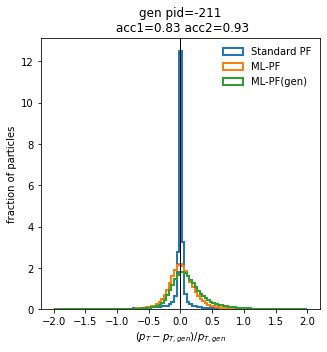

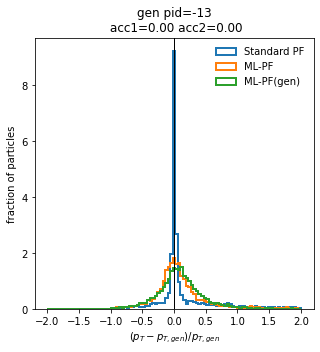

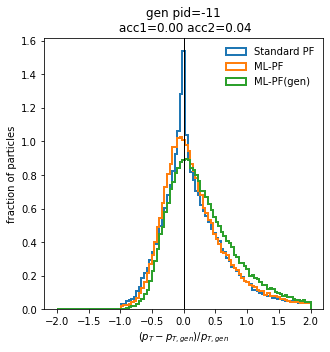

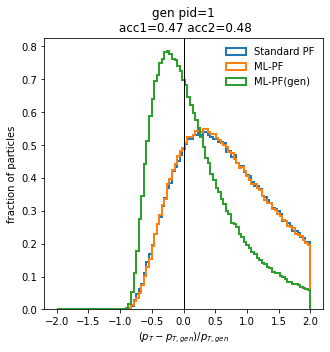

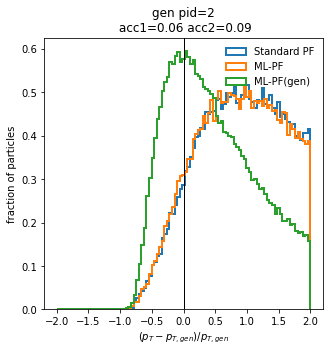

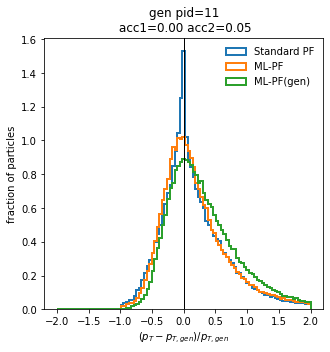

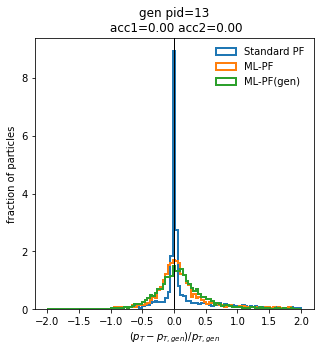

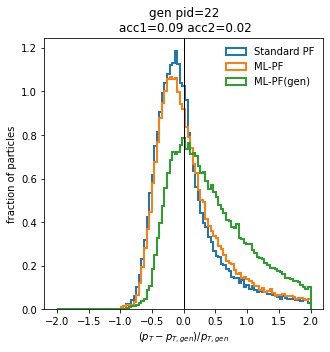

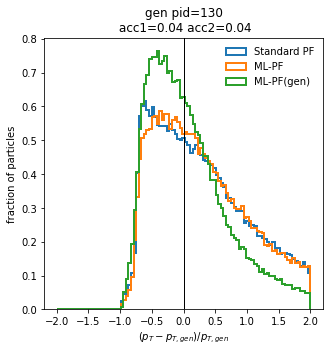

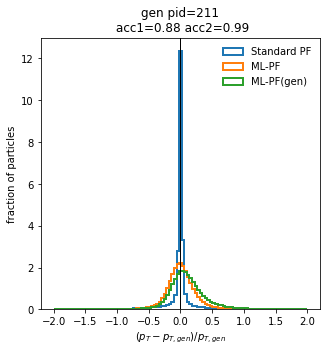

In [310]:
for p in pids:
    plt.figure(figsize=(5,5))
    chosen_class_id = train_end2end.class_labels.index(p)
    mask_class_id = (big_df["gen_class_id"]==chosen_class_id)

    mat = big_df[mask_class_id][["gen_pt", "cand_pt", "pred_pt_m1", "pred_pt_m2"]].values
    b = np.linspace(-2, 2, 100)
    plt.hist((mat[:, 1] - mat[:, 0]) / mat[:, 0], bins=b, histtype="step", lw=2, label="Standard PF", density=1.0);
    plt.hist((mat[:, 2] - mat[:, 0]) / mat[:, 0], bins=b, histtype="step", lw=2, label="ML-PF", density=1.0);
    plt.hist((mat[:, 3] - mat[:, 0]) / mat[:, 0], bins=b, histtype="step", lw=2, label="ML-PF(gen)", density=1.0);
    plt.legend(frameon=False)
    plt.axvline(0.0, color="black", lw=1.0)
    plt.xlabel("$(p_T - p_{{T,gen}}) / p_{{T,gen}}$")
    plt.ylabel("fraction of particles")
    
    acc_pf = np.sum(big_df[mask_class_id]["cand_class_id"] == chosen_class_id)/np.sum(mask_pid)
    acc_mlpfgen = np.sum(big_df[mask_class_id]["pred_class_id_m2"] == chosen_class_id)/np.sum(mask_pid)
    
    plt.title("gen pid={}\n acc1={:.2f} acc2={:.2f}".format(p, acc_pf, acc_mlpfgen))

In [313]:
n_preds = []
n_trues = []
for i in range(len(pred_ids)):
    n_true = np.sum(true_ids[i]!=0)
    n_pred = np.sum(pred_ids[i]!=0)
    n_preds += [n_pred]
    n_trues += [n_true]

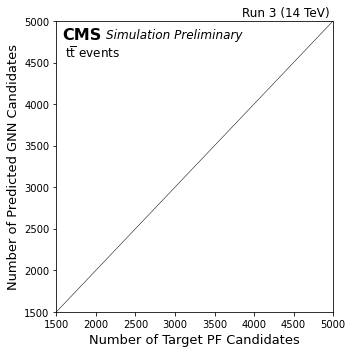

In [314]:
plt.figure(figsize=(5, 5))
ax = plt.axes()
plt.plot([1500,5000],[1500,5000], color="black", lw=0.5)
plt.scatter(n_trues, n_preds, marker=".", alpha=0.5)
plt.xlim(1500,5000)
plt.ylim(1500,5000)
plt.xlabel("Number of Target PF Candidates",fontsize=13)
plt.ylabel("Number of Predicted GNN Candidates",fontsize=13)
#plt.title("QCD Run3")

plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
#plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.tight_layout()
#plt.savefig("num_pred.pdf")

In [34]:
cms = []
for i in range(len(pred_ids)):
    cm = sklearn.metrics.confusion_matrix(
        true_ids[i],
        pred_ids[i], labels=range(len(train_end2end.class_labels))
    )
    cms += [cm]
cm = sum(cms)
cm = cm / 1000.0
cm = np.round(cm, 1)#.astype(np.int)

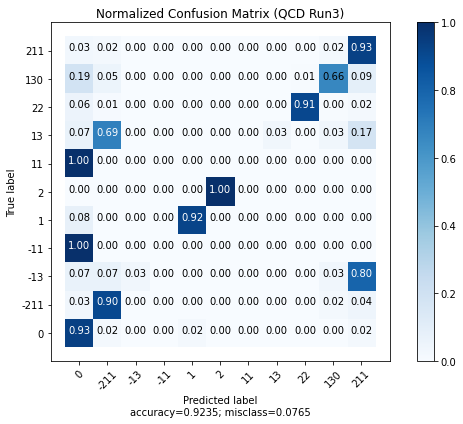

In [35]:
train_end2end.plot_confusion_matrix(cm, [int(x) for x in train_end2end.class_labels], normalize=True)
#plt.xlim(-0.5, 9.5)
#plt.ylim(-0.5, 9.5)
plt.title("Normalized Confusion Matrix (QCD Run3)")
#plt.text(0.02, 0.98, "CMS Simulation, preliminary", transform=ax.transAxes, va="top", ha="left")
#plt.tight_layout()
plt.savefig("cm.pdf")

In [36]:
pm = np.concatenate(pred_momenta)
tm = np.concatenate(true_momenta)
ti = np.concatenate(true_ids)
pi = np.concatenate(pred_ids)


pm[:, 0] = np.power(10, pm[:, 0])
tm[:, 0] = np.power(10, tm[:, 0])

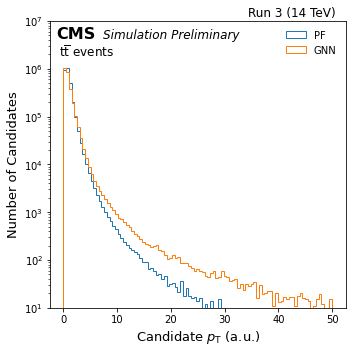

In [37]:
plt.figure(figsize=(5, 5))

ax = plt.axes()
bins = np.linspace(0, 50, 100)
h0 = plt.hist(pm[pi!=0, 0], bins=bins, histtype="step", lw=1, label="PF");
h1 = plt.hist(tm[ti!=0, 0], bins=bins, histtype="step", lw=1, label="GNN");
plt.yscale("log")
plt.legend(frameon=False)
plt.ylim(10, 1e7)

plt.xlabel("Candidate $p_{\mathrm{T}}$ (a.u.)",fontsize=13)
plt.ylabel("Number of Candidates",fontsize=13)
#plt.title("QCD Run 3")

plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
#plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.tight_layout()
plt.savefig("pt_hist.pdf")

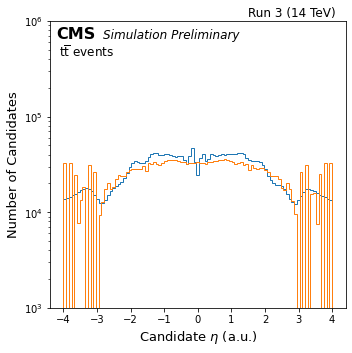

In [38]:
plt.figure(figsize=(5, 5))
ax = plt.axes()

bins = np.linspace(-4, 4, 100)
plt.hist(pm[pi!=0, 1], bins=bins, histtype="step", lw=1);
plt.hist(tm[ti!=0, 1], bins=bins, histtype="step", lw=1);
plt.yscale("log")

plt.ylim(1000, 1e6)
plt.xlabel("Candidate $\eta$ (a.u.)",fontsize=13)
plt.ylabel("Number of Candidates",fontsize=13)
#plt.title("QCD Run 3")
plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
#plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.tight_layout()
plt.savefig("eta_hist.pdf")

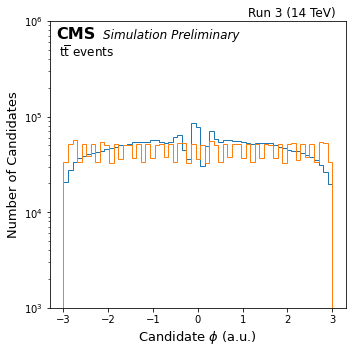

In [39]:
plt.figure(figsize=(5, 5))

ax = plt.axes()
bins = np.linspace(-3, 3, 60)
plt.hist(pm[pi!=0, 2], bins=bins, histtype="step", lw=1);
plt.hist(tm[ti!=0, 2], bins=bins, histtype="step", lw=1);
plt.yscale("log")
plt.ylim(1000, 1e6)

plt.xlabel("Candidate $\phi$ (a.u.)",fontsize=13)
plt.ylabel("Number of Candidates",fontsize=13)
#plt.title("QCD Run 3")

plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
#plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.tight_layout()
plt.savefig("phi_hist.pdf")

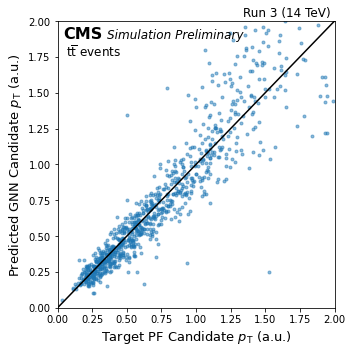

In [40]:
plt.figure(figsize=(5, 5))
ax = plt.axes()

subidx = np.where((pi!=0)&(ti!=0))[0]
rp = np.random.permutation(range(len(subidx)))[:1000]

plt.scatter(pm[subidx[rp], 0], tm[subidx[rp], 0], marker=".", alpha=0.5)
plt.xlim(0,2)
plt.ylim(0,2)
plt.plot([0,2],[0,2], color="black")

plt.xlabel("Target PF Candidate $p_{\mathrm{T}}$ (a.u.)",fontsize=13)
plt.ylabel("Predicted GNN Candidate $p_{\mathrm{T}}$ (a.u.)", fontsize=13)
#plt.title("QCD Run 3, 1000 candidates")

plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
#plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.tight_layout()
plt.savefig("pt_corr.pdf")

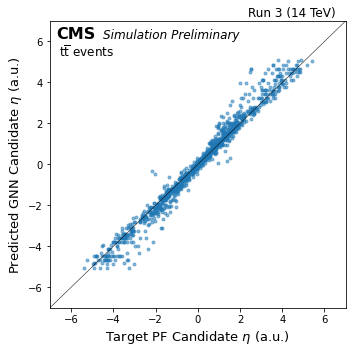

In [41]:
plt.figure(figsize=(5, 5))
ax = plt.axes()

plt.plot([-7, 7], [-7, 7], color="black", lw=0.5)
plt.scatter(pm[subidx[rp], 1], tm[subidx[rp], 1], marker=".", alpha=0.5)
plt.xlim(-7, 7)
plt.ylim(-7, 7)

plt.xlabel("Target PF Candidate $\eta$ (a.u.)",fontsize=13)
plt.ylabel("Predicted GNN Candidate $\eta$ (a.u.)",fontsize=13)
#plt.title("QCD Run 3, 1000 candidates")
plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
#plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.tight_layout()
plt.savefig("eta_corr.pdf")

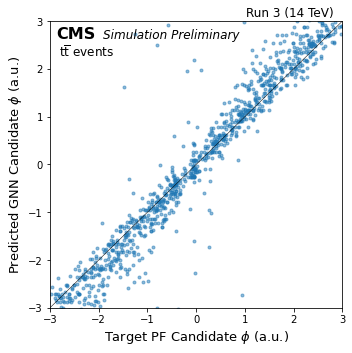

In [42]:
plt.figure(figsize=(5, 5))
ax = plt.axes()

plt.plot([-5, 5], [-5, 5], color="black", lw=0.5)
plt.scatter(pm[subidx[rp], 2], tm[subidx[rp], 2], marker=".", alpha=0.5)
plt.xlim(-3,3)
plt.ylim(-3,3)


plt.xlabel("Target PF Candidate $\phi$ (a.u.)",fontsize=13)
plt.ylabel("Predicted GNN Candidate $\phi$ (a.u.)",fontsize=13)
#plt.title("QCD Run3, 1000 candidates")

plt.text(0.67, 1.05, "Run 3 (14 TeV)", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.02, 0.98, "CMS", transform=ax.transAxes, va="top", ha="left",size=16, fontweight='bold')
plt.text(0.18, 0.975, "Simulation Preliminary", transform=ax.transAxes, va="top", ha="left",size=12,style='italic')
#plt.text(0.03, 0.92, "QCD dijet events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.text(0.03, 0.92, "$\mathrm{t}\overline{\mathrm{t}}$ events", transform=ax.transAxes, va="top", ha="left",size=12)
plt.tight_layout()
plt.savefig("phi_corr.pdf")

10114it [00:02, 3469.74it/s]                         
  0%|          | 0/5944 [00:00<?, ?it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

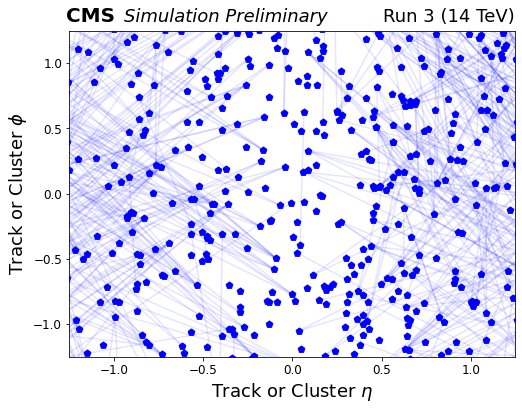

<Figure size 576x432 with 0 Axes>

In [105]:
import pandas as pd
import tqdm

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

d = full_dataset.get(1)
d.batch = torch.zeros((len(d.x)), dtype=torch.long)
d = d.to(device=device)
train_end2end.data_prep(d, device=device)
edges, cand_id_onehot, cand_momentum = model(d)
output = edges.detach().cpu().numpy()
d = full_dataset.get(1)
x_data = d.x.detach().cpu().numpy()
mask = ((x_data[:,4]==0) & (x_data[:,5]==0) & (x_data[:,6]==0) & (x_data[:,7]==0))
good_index = np.zeros((x_data.shape[0],1,2),dtype=int)
good_x = x_data[:,2:4].copy()                                                                            
good_x[~mask] = x_data[~mask,2:4].copy()
df = pd.DataFrame(good_x, columns=['eta','phi'])
df['isTrack'] = ~mask
row, col = d.edge_index.cpu().detach().numpy()
y_truth = d.ycand.cpu().detach().numpy()

min_phi = -1.25
max_phi = 1.25
min_eta = -1.25
max_eta = 1.25
extra = 1.0
x = 'eta'
y = 'phi'
for plot_type in [['input'],['truth'],['output']]: 
    k = 0
    plt.figure(figsize=(8, 6))                        
    for i, j in tqdm.tqdm(zip(row, col),total=len(y_truth)):
        x1 = df[x][i]
        x2 = df[x][j]
        y1 = df[y][i]
        y2 = df[y][j]
        if (x1 < min_eta-extra or x1 > max_eta+extra) or (x2 < min_eta-extra or x2 > max_eta+extra): continue
        if (y1 < min_phi-extra or y1 > max_phi+extra) or (y2 < min_phi-extra or y2 > max_phi+extra): continue
        if 'input' in plot_type:
            seg_args = dict(c='b',alpha=0.1,zorder=1)
            plt.plot([df[x][i], df[x][j]],
                 [df[y][i], df[y][j]], '-', **seg_args)
        if 'truth' in plot_type and y_truth[k]:
            seg_args = dict(c='r',alpha=0.8,zorder=2)
            plt.plot([df[x][i], df[x][j]],
                 [df[y][i], df[y][j]], '-', **seg_args)
        if 'output' in plot_type:
            seg_args = dict(c='g',alpha=output[k].item(),zorder=3)
            plt.plot([df[x][i], df[x][j]],
                 [df[y][i], df[y][j]], '-', **seg_args)
        k+=1
    cut_mask = (df[x] > min_eta-extra) & (df[x] < max_eta+extra) & (df[y] > min_phi-extra) & (df[y] < max_phi+extra)
    cluster_mask = cut_mask & ~df['isTrack']
    track_mask = cut_mask & df['isTrack']
    plt.scatter(df[x][cluster_mask], df[y][cluster_mask],c='g',marker='o',s=50,zorder=4,alpha=1)
    plt.scatter(df[x][track_mask], df[y][track_mask],c='b',marker='p',s=50,zorder=5,alpha=1)
    plt.xlabel("Track or Cluster $\eta$",fontsize=18)
    plt.ylabel("Track or Cluster $\phi$",fontsize=18)
    plt.xlim(min_eta, max_eta)
    plt.ylim(min_phi, max_phi)
    plt.figtext(0.12, 0.90,'CMS',fontweight='bold', wrap=True, horizontalalignment='left', fontsize=20)
    plt.figtext(0.22, 0.90,'Simulation Preliminary', style='italic', wrap=True, horizontalalignment='left', fontsize=18)
    plt.figtext(0.67, 0.90,'Run 3 (14 TeV)',  wrap=True, horizontalalignment='left', fontsize=18)
    plt.savefig('graph_%s_%s_%s.pdf'%(x,y,'_'.join(plot_type)))